In [8]:

from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities, utils
from cirkit.symbolic.layers import SumLayer, InputLayer
from cirkit.symbolic.parameters import TensorParameter, ReferenceParameter
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope

import torch

In [2]:
base_circ = data_modalities.image_data(
        (1,2,2),
        region_graph="quad-graph",
        input_layer="categorical",
        num_input_units=32,
        sum_product_layer="tucker",
        num_sum_units=32,
        num_classes=32,
        sum_weight_param=utils.Parameterization(
                activation='softmax',   
                initialization='normal' 
            )
    )

big_circ =data_modalities.image_data(
        (1,4,4),
        region_graph="quad-tree-2",
        input_layer="categorical",
        num_input_units=32,
        sum_product_layer="tucker",
        num_sum_units=32,
        sum_weight_param=utils.Parameterization(
                activation='softmax',   
                initialization='normal' 
            )
    )

In [3]:
out = base_circ.outputs[0]
out.num_output_units=32
parameter=[]
in_param={}
for parameter in out.weight.topological_ordering():
    print(parameter)
    parameter._shape = (32,2)
out.weight.outputs._shape

AttributeError: 'list' object has no attribute '_shape'

In [5]:
from cirkit.symbolic.parameters import Parameter
def copy_parameter(graph:Parameter):
    new_param_nodes = []
    copy_map = {}
    in_nodes ={}
    outputs=[]
    for n in graph.topological_ordering():
        instance = type(n)
        if instance == TensorParameter:
            new_param = ReferenceParameter(n) 
        else:
            new_param = instance(**n.config)
        new_param_nodes.append(new_param)
        copy_map[n]=new_param
        inputs = [copy_map[in_node] for in_node in graph.node_inputs(n)]
        if len(inputs)>0:
            in_nodes[new_param]=inputs
    outputs = [copy_map[out_node] for out_node in graph.outputs]
    return Parameter(nodes=new_param_nodes, in_nodes=in_nodes, outputs=outputs)

def copy_circuit(graph:Circuit, scope_map:dict[int, int], root_node_outputs=None):
    new_circ_layers = []
    copy_map = {}
    in_nodes ={}
    outputs=[]
    copied_params=[]
    for layer in graph.topological_ordering():
        instance = type(layer)
        if isinstance(layer, SumLayer):
            if layer.weight in copied_params:
                parameter = copy_parameter(layer.weight)
            else:
                parameter=layer.weight
                copied_params.append(layer.weight)
            new_config = layer.config
            new_layer = SumLayer(
                **new_config,
                weight = parameter
                )
        if isinstance(layer, InputLayer):
            params = list(layer.params.items())
            p_key = params[0][0]
            p_graph = params[0][1]
            new_scope = Scope([scope_map[s] for s in layer.scope])
            config = copy(layer.config)
            del config["scope"]
            if p_graph in copied_params:
                new_p_graph = copy_parameter(p_graph)
            else:
                new_p_graph=p_graph
                copied_params.append(p_graph)
            new_layer = instance(scope= new_scope, **config, **{p_key:new_p_graph})
        else:
            new_config = layer.config
            new_layer = instance(**new_config, **layer.params)
        new_circ_layers.append(new_layer)
        copy_map[layer]=new_layer
        inputs = [copy_map[in_node] for in_node in graph.node_inputs(layer)]
        if len(inputs)>0:
            in_nodes[new_layer]=inputs
    outputs = [copy_map[out_node] for out_node in graph.outputs ]
    if root_node_outputs is not None:
        for n in outputs:
            n.num_output_units=root_node_outputs
    return new_circ_layers, in_nodes,outputs

print( base_circ.outputs)
print(copy_circuit(base_circ,scope_map)[2])
print(scope_map)

[SumLayer(num_input_units=32, num_output_units=32, arity=2, config=(num_input_units=32, num_output_units=32, arity=2), params=(weight=Parameter(shape=(32, 64)))]


NameError: name 'scope_map' is not defined

In [6]:
from copy import copy 

def detect_list(dicti):
    for el in dicti:
        for sub_el in dicti[el]:
            if isinstance(sub_el, list):
                return True
    return False

layers= copy(big_circ.nodes)
in_layers = copy(big_circ.nodes_inputs)


layers_to_replace = []
for n in big_circ.layerwise_topological_ordering():
    if len(big_circ.layer_scope(n[0]))==4 and isinstance(n[0], SumLayer):
        layers_to_replace = n
        break

if detect_list(in_layers):
            print("ERROR LIST DETECTED")
            raise Error()

entry_points_map={}
for l in layers_to_replace:
    for sl in big_circ.subgraph(l).topological_ordering():
        to_remove=[sl]
        while len(to_remove)>0:
            tr = to_remove.pop()
            if tr in in_layers:
                to_remove.extend(in_layers[tr])
                del in_layers[tr]
            if tr in layers:
                layers.remove(tr)

        if detect_list(in_layers):
            print("ERROR LIST DETECTED")
            raise Error()
    scope_map=dict(zip(base_circ.scope, big_circ.layer_scope(l)))
    new_subgraph_layers, new_subgraph_inputs, new_output = copy_circuit(base_circ, scope_map, root_node_outputs=sl.num_output_units)
    layers.extend(new_subgraph_layers)
    in_layers.update(new_subgraph_inputs)

    entry_points_map[sl]=new_output
    if detect_list(in_layers):
        print("ERROR LIST DETECTED")
        raise Error()

for old, new in entry_points_map.items():
    for node, inputs in in_layers.items():
        if old in inputs:
            in_layers[node].remove(old)
            in_layers[node].extend(new)

if detect_list(in_layers):
    print("ERROR LIST DETECTED")
# pprint(in_layers)
new_circ = Circuit(
    layers = layers,
    in_layers=in_layers,
    outputs= big_circ.outputs
)
from cirkit.pipeline import compile
cc=compile(new_circ)

In [10]:
new_circ.outputs

[SumLayer(num_input_units=1024, num_output_units=1, arity=1, config=(num_input_units=1024, num_output_units=1, arity=1), params=(weight=Parameter(shape=(1, 1024)))]

In [9]:
cc(torch.randn((2,16)))

tensor([[[-89.5269]],

        [[-90.2221]]], grad_fn=<TransposeBackward0>)

In [ ]:
base_circ.outputs

[SumLayer(num_input_units=32, num_output_units=32, arity=2, config=(num_input_units=32, num_output_units=32, arity=2), params=(weight=Parameter(shape=(32, 64)))]

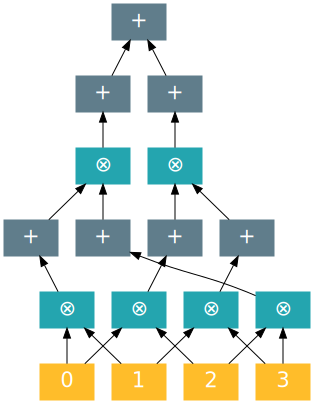

In [ ]:
plot_circuit(base_circ)

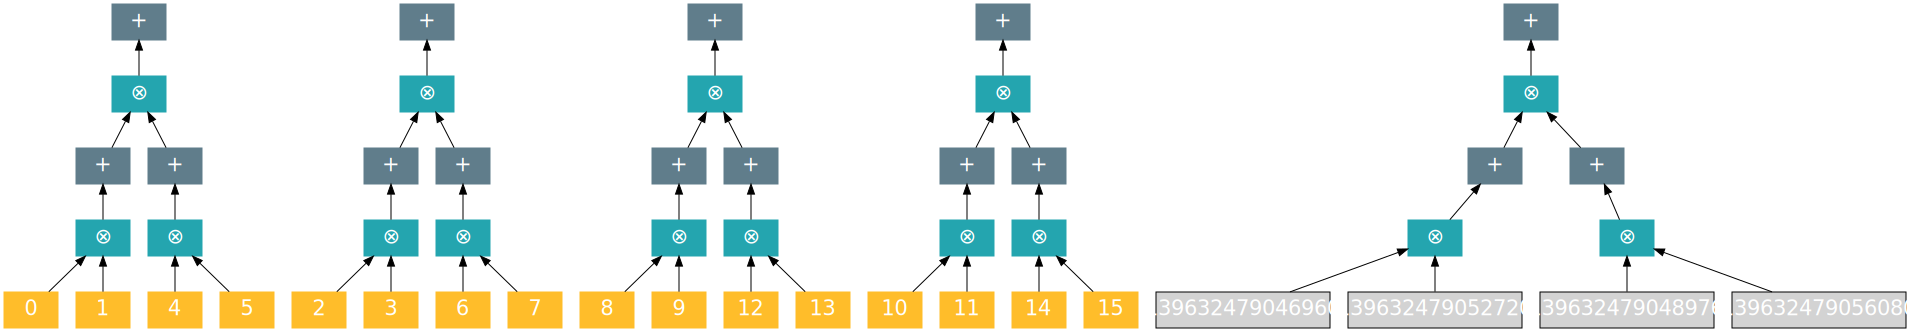

In [ ]:
plot_circuit(big_circ)


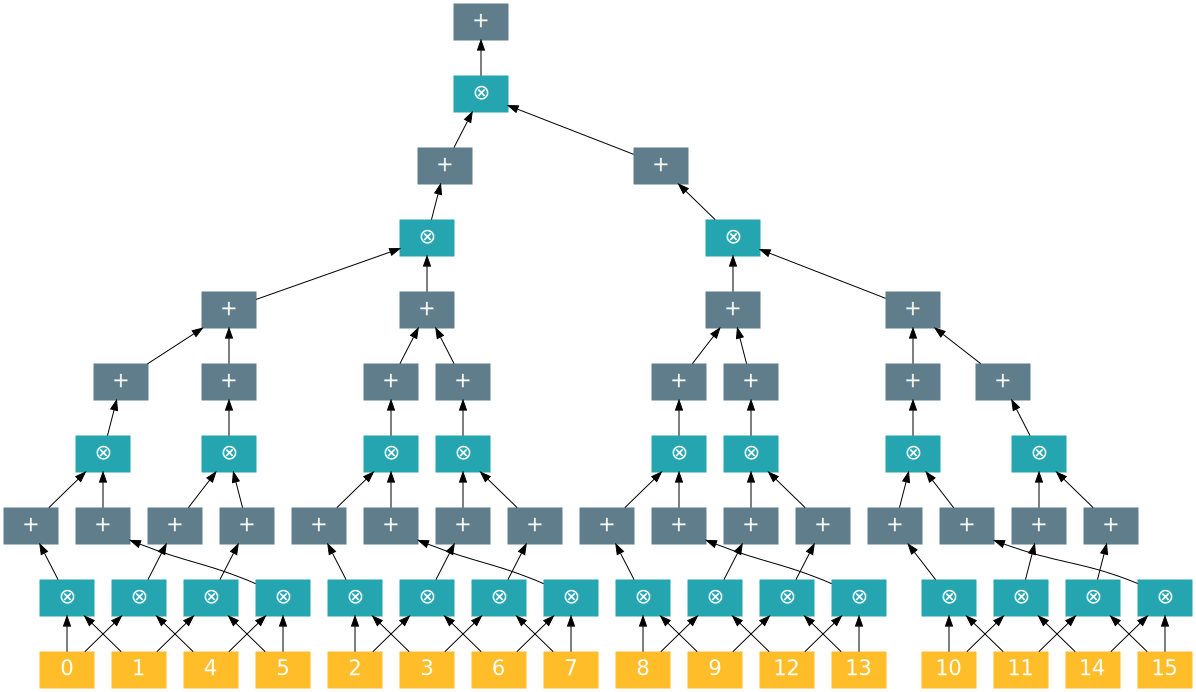

In [ ]:
plot_circuit(new_circ)

In [ ]:
one = list(new_circ.inputs)[1]
two = list(new_circ.inputs)[5]

list(one.params['probs'].topological_ordering())[0].deref(), list(two.params['probs'].topological_ordering())[0].deref()

(<cirkit.symbolic.parameters.TensorParameter at 0x7f7dd82c41f0>,
 <cirkit.symbolic.parameters.TensorParameter at 0x7f7dd82c41f0>)